In [18]:
import numpy as np
import unityneuro.render as urn
import matplotlib.pyplot as plt
import pandas as pd
import time

In [2]:
urn.setup()

(URN) connected to server
Login sent with ID: Dan


In [3]:
# load ontology structure to swap #s for acronyms
ontology = pd.read_csv('./ontology_structure_minimal.csv')
atlas_id = ontology.atlas_id.values
beryl_id = ontology.beryl_id.values
acronym = ontology.acronym.values

def id2acronym(id):
  if np.any(beryl_id==id):
    return acronym[beryl_id==id][0]
  
  return None

In [4]:
allen_labels = np.load('./PETH_area_label.npy')
beryl_labels = np.load('./PETH_ses_id.npy')

stim = np.load('./PETH_stim.npy')
move = np.load('./PETH_move.npy')
feedback = np.load('./PETH_feedback.npy')

In [36]:
base_temp = np.mean(stim[:,0:19,:],axis=1) + 0.1
baseline = np.mean(base_temp,axis=1)
baseline = np.expand_dims(baseline, [1, 2])
# baseline = np.zeros((base_temp.shape[0], 50, base_temp.shape[1]))
# for i in np.arange(0,50):
#   baseline[:,i,:] = base_temp

In [38]:
stim_bn = np.divide(np.clip(stim - baseline, 0, np.Inf), baseline)
move_bn = np.divide(np.clip(move - baseline, 0, np.Inf), baseline)
feed_bn = np.divide(np.clip(feedback - baseline, 0, np.Inf), baseline)

In [97]:
# Compute left/right difference
stim_lr = stim_bn[:,:,2] + stim_bn[:,:,0]

In [101]:
# get all neurons from each brain area, average them
uareas = np.unique(beryl_labels)

stim_area = np.zeros((len(uareas), stim_lr.shape[1]))

for i,area in enumerate(uareas):
  area_idx = beryl_labels==area
  
  stim_area[i,:] = np.mean(stim_lr[area_idx,:], axis=0)

# square to make it easier to see differences (and to make abs value)
# stim_area = np.power(stim_area, 2)
stim_area = np.abs(stim_area)
stim_area = np.clip(stim_area, 0, 5)/5
# stim_area = stim_area / np.max(stim_area)

In [102]:
stim_area.shape

(260, 50)

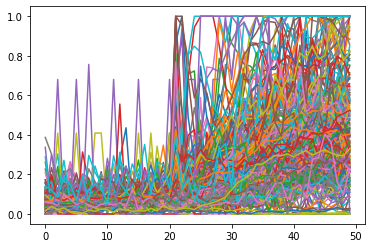

In [103]:
plt.figure()
plt.plot(stim_area.T);

In [125]:
urn.clear_areas()


In [114]:

area_vis = {}
area_mat = {}
missing_area_vis = {}

acronyms = {}
suffixes = ['-lh','-rh']

for i, area_id in enumerate(uareas):
  area_name = id2acronym(area_id)

  if area_name is not None:
    acronyms[i] = []
    for suffix in suffixes:
      an = area_name + suffix
      area_vis[an] = True
      area_mat[an] = 'opaque-unlit'
      acronyms[i].append(an)

# for area_id in beryl_id:
#   if area_id not in uareas:
#     area_name = id2acronym(area_id)

#     if area_name is not None:
#       missing_area_vis[area_name] = True


urn.set_area_visibility(area_vis)
urn.set_area_material(area_mat)
# urn.set_area_visibility(missing_area_vis)

In [56]:
urn.set_area_colormap('grey-purple')

In [106]:
urn.create_text(['t1'])

In [115]:
timepoints = np.arange(-0.2,0.3,0.5/50)

for di in [0]: #np.arange(0,50):
    urn.set_text({'t1':f'Time: {timepoints[di]:.2f}'})
    area_intensity = {}

    for idx in acronyms.keys():
        for area_name in acronyms[idx]:
            area_intensity[area_name] = stim_area[idx,di]

    urn.set_area_intensity(area_intensity)

    time.sleep(0.2)